In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%reset -f -s
import logging
import random
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import ImageDraw, ImageFont, Image
from datasets import ClassLabel, load_dataset, Features, Image as DsImage, Value
from skrub import TableReport

from digression_code import (show_examples, show_predictions, Task, PTModel, FTModel, FTFExtractor, load_annotations_csv)
logging.basicConfig(level=logging.INFO)
logging.getLogger("matplotlib").setLevel(logging.CRITICAL)
logging.getLogger("PIL").setLevel(logging.CRITICAL)

def _ds_features(task: Task) -> Features:
    return Features({'image': DsImage(),
                    'labels': task.labels,
                    'id': Value(dtype='string')})


In [23]:
task = Task("angle_to_row")
ds = load_dataset("imagefolder", data_dir=f"ifd-data/{task.name}", features=_ds_features(task))
ds

Resolving data files:   0%|          | 0/15001 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/5001 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'labels', 'id'],
        num_rows: 15000
    })
    test: Dataset({
        features: ['image', 'labels', 'id'],
        num_rows: 5000
    })
})

In [24]:
def _umap_project(embeddings):
    ft_tree = FTFExtractor.annoy_tree(embeddings)
    ft_dist = FTFExtractor.pairwise_distances(ft_tree)
    ft_umap = FTFExtractor.umap_projection(ft_dist)
    return ft_umap, ft_dist

def _df_umap(umap_feat, slice_ds, task):
    ft_umap_df = (FTFExtractor.umap_projection_df(umap_feat, slice_ds['labels'], slice_ds['id'])
                .assign(label_name=lambda x: [task.labels.int2str(_) for _ in x.label]))
    return ft_umap_df


split = 'test'
slice_ds = ds[split]
ft_embeddings = np.load(f"./embeddings/{task.name}/{split}.npy")
ft_umap, ft_dist = _umap_project(ft_embeddings)
ft_umap_df = _df_umap(ft_umap, slice_ds, task)

fou_embeddings = np.load(f"./embeddings/foundation-{task.name}/{split}.npy")
fou_umap, fou_dist = _umap_project(fou_embeddings)
fou_umap_df = _df_umap(fou_umap, slice_ds, task)


KNN Tree:   0%|          | 0/5000 [00:00<?, ?it/s]

Pairwise Distances:   0%|          | 0/25000000 [00:00<?, ?it/s]

KNN Tree:   0%|          | 0/5000 [00:00<?, ?it/s]

Pairwise Distances:   0%|          | 0/25000000 [00:00<?, ?it/s]

In [25]:
ft_umap_df.head().assign(image=lambda x: [Path(f"ifd-data/{task.name}/{split}/{row.label_name}/{row.image_id}.png") for i, row in x.iterrows()])

x         y  label                  image_id label_name  \
0 -5.582233  1.116304      2  5eb71c8e3730635fa267d522     ANGLED   
1 -6.850753 -1.825069      2  5eb71c913730635fa267d59a     ANGLED   
2 -6.965974  0.034538      2  5eb7205448dbaddc57b498fb     ANGLED   
3 -6.381146 -2.066682      2  5ebee176e66d7d2ba085189f     ANGLED   
4 -7.162112 -0.273190      2  5ec6d9af949b6ca997219cd8     ANGLED   

                                               image  
0  ifd-data/angle_to_row/test/ANGLED/5eb71c8e3730...  
1  ifd-data/angle_to_row/test/ANGLED/5eb71c913730...  
2  ifd-data/angle_to_row/test/ANGLED/5eb7205448db...  
3  ifd-data/angle_to_row/test/ANGLED/5ebee176e66d...  
4  ifd-data/angle_to_row/test/ANGLED/5ec6d9af949b...

In [26]:
row = ft_umap_df.iloc[0]
Path(f"ifd-data/{task.name}/{split}/{row.label_name}/{row.image_id}.png").exists()


True

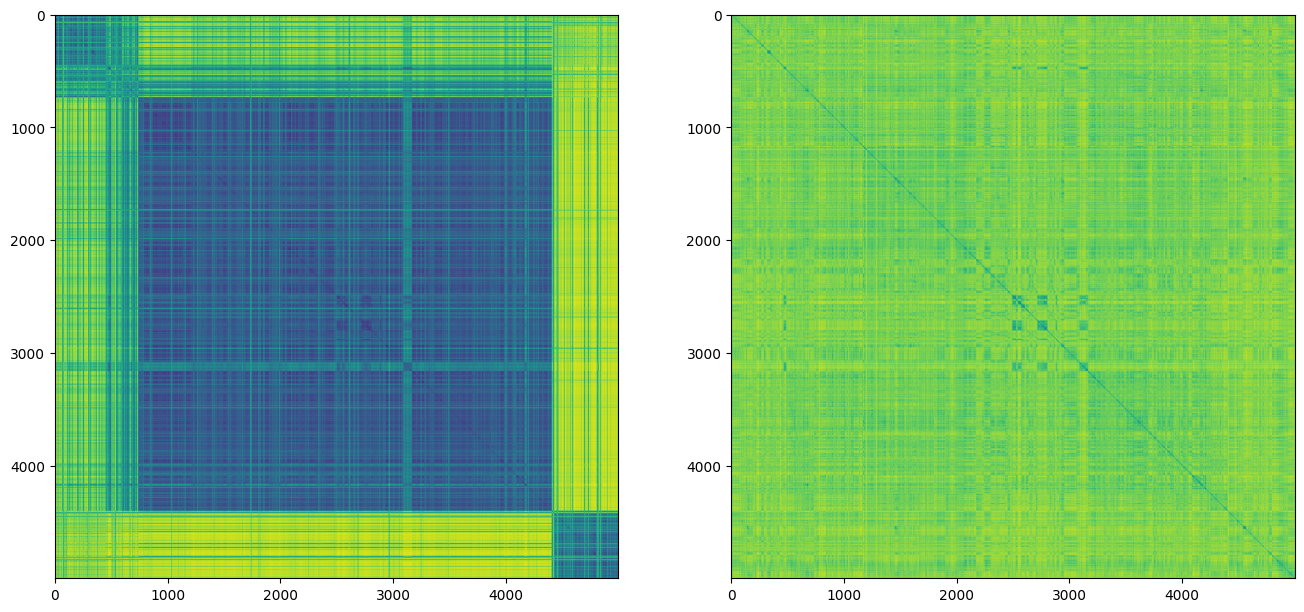

In [27]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax[0].imshow(ft_dist)
ax[1].imshow(fou_dist)


In [28]:
plot_df = pd.merge(
    pd.concat([ft_umap_df.assign(model="fine-tuned"), fou_umap_df.assign(model="foundation")]),
    pd.read_csv(f"./predictions/{task.name}/test.csv").rename(columns={"y_tilde": "label"}),
    on=["image_id", "label"]).assign(pred_name=lambda x: [task.labels.int2str(_) for _ in x.y_hat])
plot_df

x         y  label                  image_id     label_name  \
0    -5.582233  1.116304      2  5eb71c8e3730635fa267d522         ANGLED   
1    -6.850753 -1.825069      2  5eb71c913730635fa267d59a         ANGLED   
2    -6.965974  0.034538      2  5eb7205448dbaddc57b498fb         ANGLED   
3    -6.381146 -2.066682      2  5ebee176e66d7d2ba085189f         ANGLED   
4    -7.162112 -0.273190      2  5ec6d9af949b6ca997219cd8         ANGLED   
...        ...       ...    ...                       ...            ...   
9995  8.470150  6.184580      1  6132846bf44f306d3ee74943  PERPENDICULAR   
9996  9.719586  5.827820      1  614a4158285c153b503e6b49  PERPENDICULAR   
9997  9.672478  5.789897      1  614a42284c80ecdc5701e7fb  PERPENDICULAR   
9998  8.479626  5.892314      1  614a5d2f599aef4952a5c5aa  PERPENDICULAR   
9999  6.154560  7.482026      1  614a5e1f32272a54ed95c6cf  PERPENDICULAR   

           model  y_hat  PARALLEL  PERPENDICULAR    ANGLED      pred_name  
0     fine-tuned      2  0.071985       0.363436  0.564579         ANGLED  
1     fine-tuned      2  0.035032       0.044696  0.920272         ANGLED  
2     fine-tuned      2  0.027595       0.066154  0.906251         ANGLED  
3     fine-tuned      2  0.036651       0.037452  0.925898         ANGLED  
4     fine-tuned      2  0.028100       0.051978  0.919922         ANGLED  
...          ...    ...       ...            ...       ...            ...  
9995  foundation      1  0.047632       0.902958  0.049410  PERPENDICULAR  
9996  foundation      1  0.042773       0.898265  0.058962  PERPENDICULAR  
9997  foundation      1  0.026824       0.931511  0.041665  PERPENDICULAR  
9998  foundation      1  0.036287       0.923471  0.040242  PERPENDICULAR  
9999  foundation      1  0.024189       0.942644  0.033166  PERPENDICULAR  

[10000 rows x 11 columns]

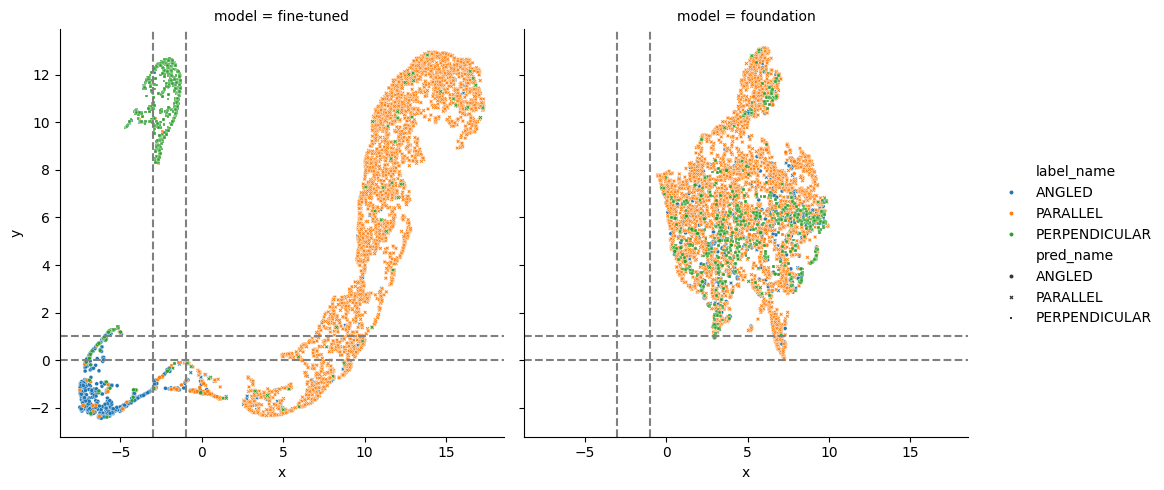

In [29]:
import seaborn as sns
sns.relplot(
    data=plot_df, x='x', y='y', hue='label_name', col='model', style='pred_name', s=8
).refline(y=0).refline(y=1).refline(x=-3).refline(x=-1)

In [30]:
from renumics import spotlight
from tqdm.auto import tqdm
def _get_path(row):
    return str(Path(f"ifd-data/{task.name}/{split}/{row.label_name}/{row.image_id}.png"))


all_embeddings_df = pd.concat([
    ft_umap_df.assign(embeddings=lambda x: [ft_embeddings[i] for i in range(len(x))],
                      image=lambda x: tqdm([_get_path(row) for i, row in x.iterrows()]),
                      model='fine-tuned'),
    fou_umap_df.assign(embeddings=lambda x: [fou_embeddings[i] for i in range(len(x))],
                      image=lambda x: [_get_path(row) for i, row in x.iterrows()],
                      model='foundation'),
])
alth_df = load_annotations_csv(f"wrong_crop_model/62340e30573f02a7303dd8b6.alth/annotations.csv").reset_index().rename(columns={"id": "image_id"})
#alth_df.head()

spotlight_df = pd.merge(
    alth_df,
    pd.merge(all_embeddings_df, plot_df, on=["x", "y", "label", "label_name", "image_id", "model"]),
    on=["image_id"]
)

# from sliceguard import SliceGuard
# from sklearn.metrics import accuracy_score
# from renumics import spotlight

# sg = SliceGuard()
# issues = sg.find_issues(spotlight_df, features=["image"], y="label", metric=accuracy_score)
# report_df, spotlight_data_issues, spotlight_dtypes, spotlight_layout = sg.report(no_browser=True)
# spotlight.show(report_df, dtype=spotlight_dtypes, issues=spotlight_data_issues, layout=spotlight_layout,)



  0%|          | 0/5000 [00:00<?, ?it/s]

In [31]:
spotlight.show(spotlight_df, dtype={"image": spotlight.Image, "embeddings": spotlight.Embedding})




(184, 11)


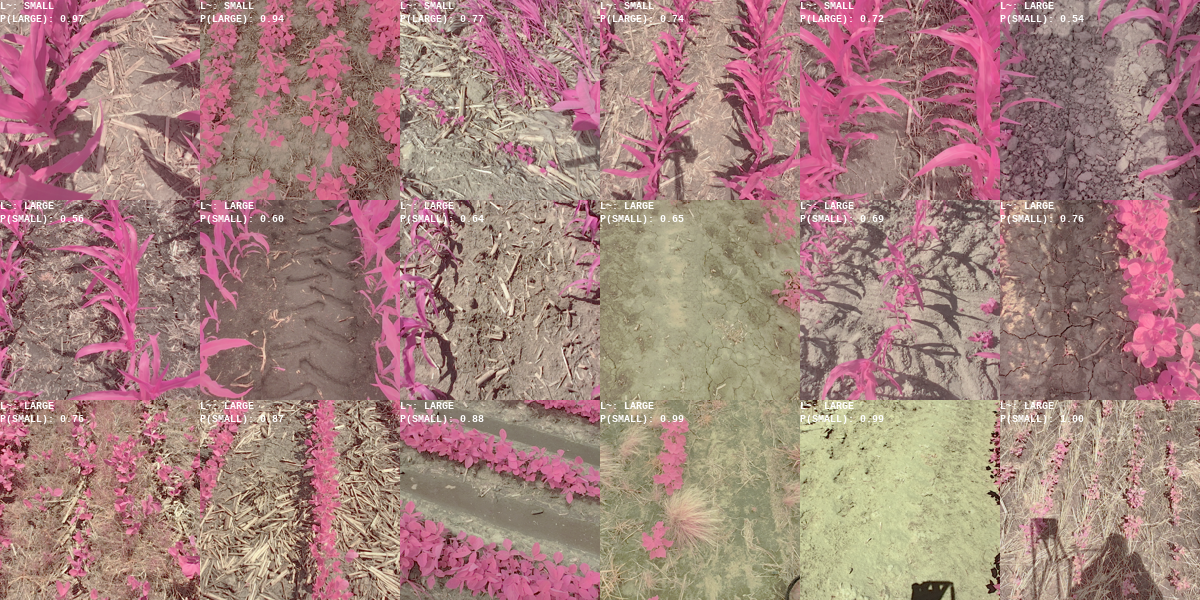

In [11]:

def show_issues(task: Task, pred_df: pd.DataFrame, sample_n=9, col_wrap=2, size=(350, 350)):

    w, h = size
    grid = Image.new('RGB', size=(col_wrap * w, (sample_n // col_wrap + sample_n % col_wrap) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf",
                              {100: 8, 150: 8, 200: 10, 350: 12}[size[0]])


    for i, (_, row) in enumerate(pred_df.sample(n=sample_n).sort_values(by=["label", task.labels.names[0]]).iterrows()):
        image = Image.open(Path(row.abs_path))

        ex_label = f"L~: {task.labels.int2str(row["label"])}"
        pred_label = task.labels.int2str(row["y_hat"])
        pred_score = row[f"{pred_label}"]
        ex_pred = f"P({task.labels.int2str(row["y_hat"])}): {pred_score:.2f}"

        box = (i % col_wrap * w, i // col_wrap * h)
        grid.paste(image.resize(size), box=box)
        draw.multiline_text(box, f"{ex_label}\n{ex_pred}", (255, 255, 255), font=font)

    return grid

def _path_func(row,
                base_path=f"ifd-data/{task.name}/{split}",
                i2s=task.labels.int2str):
    return f"{base_path}/{i2s(row.label)}/{row.image_id}.png"



issue_df = (plot_df
            .loc[lambda x: (
 #               (0 <= x.y) & (x.y <= 1) & (-3 <= x.x) & (x.x <= -1) &
                (x.pred_name != x.label_name))]
            .assign(abs_path=lambda x: [_path_func(row) for _, row in x.iterrows()]))
print(issue_df.shape)
show_issues(task, issue_df,  sample_n=18, col_wrap=6, size=(200, 200))

In [9]:
from sklearn.metrics import classification_report
from digression_code import tasks

def _test_perf(task_name):
    eval_task = Task(task_name)
    eval_df = pd.read_csv(f"./predictions/{eval_task.name}/test.csv")
    evals_res_df = pd.DataFrame(classification_report(y_true=eval_df.y_tilde, y_pred=eval_df.y_hat, target_names=eval_task.labels.names, output_dict=True))
    return evals_res_df

_test_perf(task.name)


SMALL       LARGE  accuracy    macro avg  weighted avg
precision     0.991938    0.947368  0.986857     0.969653      0.986806
recall        0.993219    0.937965  0.986857     0.965592      0.986857
f1-score      0.992578    0.942643  0.986857     0.967611      0.986829
support    6194.000000  806.000000  0.986857  7000.000000   7000.000000

## Below is one way to show the initial aletheia dataset

In [ ]:
import pandas as pd
from skrub import TableReport
keep_cols = [
    'angle_to_row',  # DONE
    'cloud_cover',   # DONE
    'crop_damage',
    'crop_health',
    'crop_height',   # DONE
    'crop_name',     # DONE
    'crop_residue',  # DONE
    'crop_residue_type',
    'row_spacing',   # DONE
    # 'soil_color',  # Bad results/data
    'soil_moisture',
    'tillage_practice', # DONE
    # 'weed_pressure',
    'weeds',
]

#_df = pd.read_csv("wrong_crop_model/62340e30573f02a7303dd8b6.alth/annotations.csv")[keep_cols]#.drop(columns=["id", "file_name"])
_df = pd.read_csv("wrong_crop_model/62340e30573f02a7303dd8b6.angle_to_row/train/metadata.csv")
TableReport(_df)


Processing column  14 / 14


<TableReport: use .open() to display>

In [ ]:
_df.loc[lambda x: x.id == '5eeb8f856e4ced6de9c32b0c']

id                            file_name  labels  \
83  5eeb8f856e4ced6de9c32b0c  ANGLED/5eeb8f856e4ced6de9c32b0c.png  ANGLED   
84  5eeb8f856e4ced6de9c32b0c  ANGLED/5eeb8f856e4ced6de9c32b0c.png  ANGLED   
85  5eeb8f856e4ced6de9c32b0c  ANGLED/5eeb8f856e4ced6de9c32b0c.png  ANGLED   
86  5eeb8f856e4ced6de9c32b0c  ANGLED/5eeb8f856e4ced6de9c32b0c.png  ANGLED   

   cloud_cover crop_damage crop_health crop_height crop_name crop_residue  \
83    OVERCAST    ['NONE']     HEALTHY      MEDIUM  SOYBEANS       MEDIUM   
84    OVERCAST    ['NONE']     HEALTHY      MEDIUM  SOYBEANS       MEDIUM   
85    OVERCAST    ['NONE']     HEALTHY      MEDIUM  SOYBEANS       MEDIUM   
86    OVERCAST    ['NONE']     HEALTHY      MEDIUM  SOYBEANS       MEDIUM   

   crop_residue_type row_spacing soil_moisture tillage_practice  \
83               NaN   INCHES_30           NaN     CONVENTIONAL   
84               NaN   INCHES_30           NaN     CONVENTIONAL   
85               NaN   INCHES_30           NaN     CONVENTIONAL   
86               NaN   INCHES_30           NaN     CONVENTIONAL   

                                                weeds  
83  ['OTHER_BROADLEAF', 'VELVETLEAF', 'VOLUNTEER_C...  
84  ['OTHER_BROADLEAF', 'VELVETLEAF', 'VOLUNTEER_C...  
85  ['OTHER_BROADLEAF', 'VELVETLEAF', 'VOLUNTEER_C...  
86  ['OTHER_BROADLEAF', 'VELVETLEAF', 'VOLUNTEER_C...